# Extra examples

Yeah, I can't think of any names.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Literal, Optional
from samplics.categorical import CrossTabulation

gss_saf = pd.read_csv("data/safiya_clean.csv")
gss_theo = pd.read_csv("data/theo_clean.csv")


def recode_age(age: int | Literal[np.nan, pd.NA]):
    """Destroy age by recoding it into a category.

    Parameters
    ----------
    age: int | Literal[np.nan, pd.NA]
        `age` feature from GSS.
    
    Returns
    -------
    str
        Lossy, categorized age as a string.
    """
    if age in range(18, 30):
        return "18-29"
    elif age in range(30, 40):
        return "30-39"
    elif age in range(40, 50):
        return "40-49"
    elif age in range(50, 60):
        return "50-59"
    elif age in range(60, 70):
        return "60-69"
    elif age > 69:
        return "70+"
    else:
        return pd.NA


def crosstab_barplots(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: Optional[str] = None,
    weight: Optional[str] = None,
    stratum: Optional[str] = None,
    psu: Optional[str] = None,
    percents: Optional[bool] = True,
    palette: Optional[list[str] | dict[str, str]] = None,
    figsize: Optional[tuple[int, int]] = (8, 6),
    title: Optional[str] = None,
) -> (plt.Figure, plt.Axes):
    """Meow."""

    # Calculate cross tabulation
    tab_ct: CrossTabulation = CrossTabulation("proportion")
    tab_ct.tabulate(
        vars=df[[x, y]],
        samp_weight=df[weight] if weight else None,
        stratum=df[stratum] if stratum else None,
        psu=df[psu] if psu else None,
        remove_nan=True,
    )
    table: pd.DataFrame = tab_ct.to_dataframe()

    # Convert to percents if asked
    if percents:
        table["proportion"] = ethn_age_tab["proportion"] * 100

    # Plot bar
    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(
        x=x, y="proportion", hue=hue, data=table, palette=palette, ax=ax
    )

    # Title
    ax.set_title(title, fontsize=16, fontweight="bold")

    # Remove unimportant ink
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    # Remove legend title
    legend: plt.legend.Legend = ax.get_legend()
    legend.set_title(None)
    legend.draw_frame(False)

    # Remove spines and set the layout to tight
    sns.despine(fig, ax)
    fig.set_tight_layout(True)

    return fig, ax


gss_theo["age_cat"] = gss_theo["age"].map(recode_age)


## Additional cross tabs

In [5]:
tab_imm_race = CrossTabulation("proportion")
tab_imm_race.tabulate(
    vars=gss_saf[["hs_or_college", "decrease_imm"]],
    samp_weight=gss_saf["wtssnrps"],
    # stratum=gss_saf["vstrat"],
    psu=gss_saf["vpsu"],
    remove_nan=True,
)

tab_imm_race.to_dataframe()


,hs_or_college,decrease_imm,proportion,stderror,lower_ci,upper_ci
0,HS or less,Decrease,0.272837,0.011852,0.250221,0.296688
1,HS or less,Stay the same or increase,0.344438,0.007144,0.330565,0.358581
2,Some college,Decrease,0.126738,0.006214,0.115043,0.139434
3,Some college,Stay the same or increase,0.255988,0.013433,0.230542,0.283208


In [ ]:
gss_saf


,year,age,income,education_cat,president_cat,sex_cat,race_cat,party_cat,language_cat,attitude_cat,immigration_cat,vpsu,vstrat,wtssnrps
0,2010,31.0,66239.250,College,Obama,Male,Other,Democrat,Yes,Remained the same,Stay same and Increase,1,2240,1.083753
1,2010,23.0,13047.125,College,Obama,Female,White,Democrat,No,Increased a little,Stay same and Increase,1,2240,0.456877
2,2010,71.0,17061.625,High school or less,Obama,Female,Black,Democrat,Yes,Reduced a little,Reduce,2,2240,0.462404
3,2010,82.0,7226.100,High school or less,Obama,Female,White,Republican,No,Remained the same,Stay same and Increase,2,2240,0.557622
4,2010,78.0,NaN,No schooling,Obama,Female,Black,Independent,No,NaN,NaN,1,2241,1.286242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15798,2021,21.0,6048.000,College,Trump,Female,White,Democrat,Yes,Increased a little,Stay same and Increase,1502,2655,3.585827
15799,2021,29.0,80640.000,College,Trump,Female,White,Republican,No,Reduced a little,Reduce,4056,2657,0.833348
15800,2021,NaN,168736.297,College,Trump,Female,Other,Democrat,Yes,Remained the same,Stay same and Increase,1705,2659,1.042119
15801,2021,68.0,1344.000,Ph. D/Doctorate,Trump,Female,White,Democrat,Yes,Increased a little,Stay same and Increase,3192,2652,0.637692


## Plots

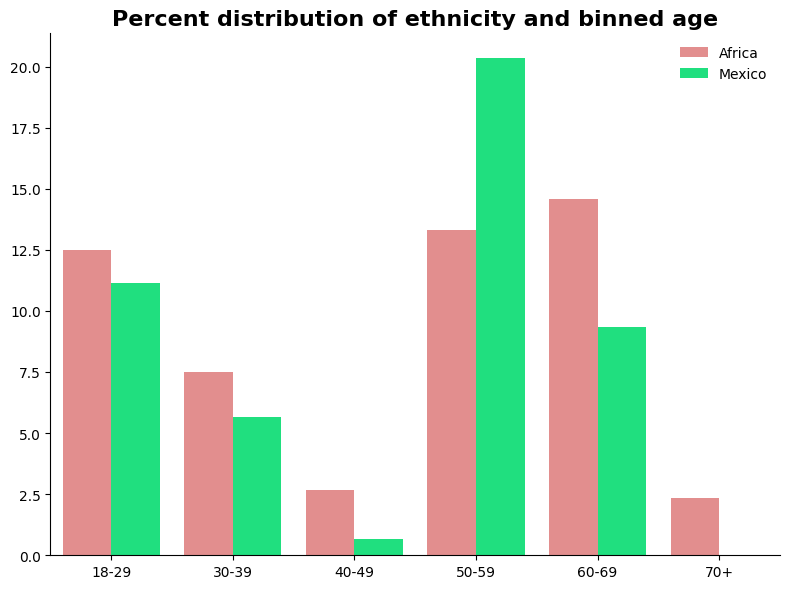

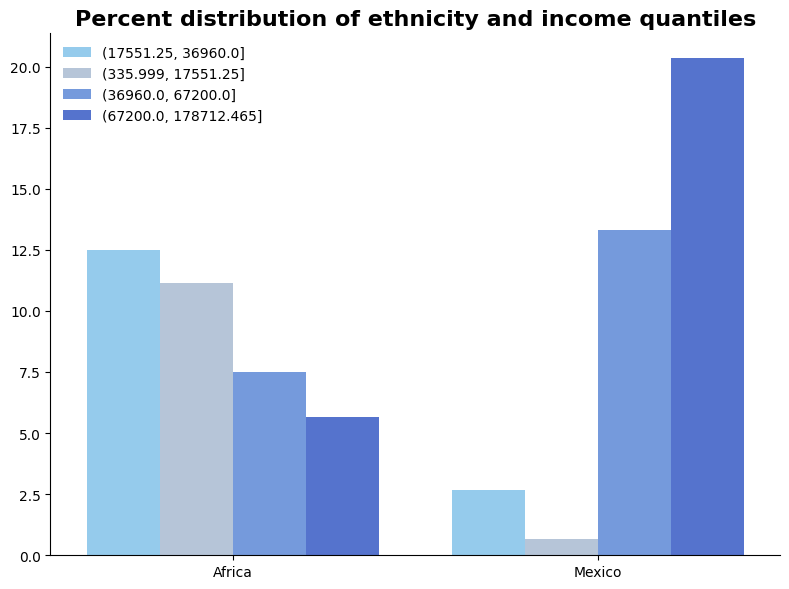

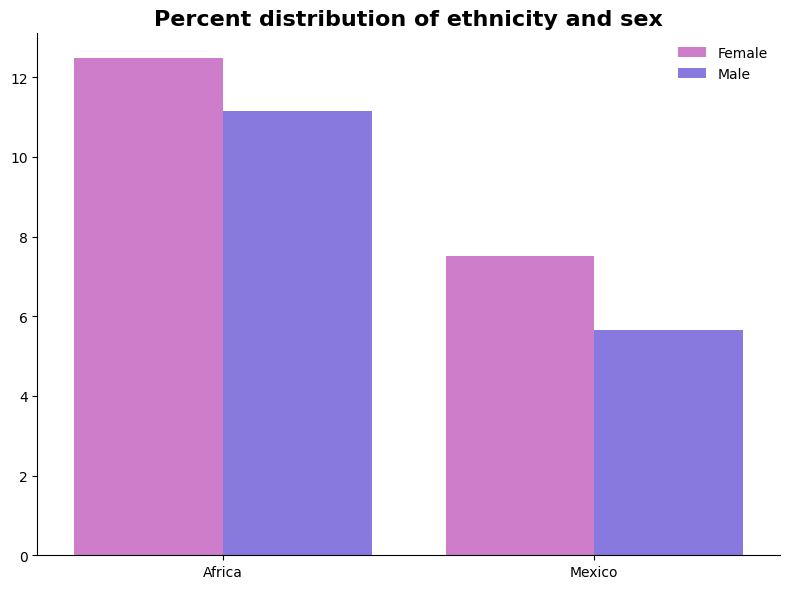

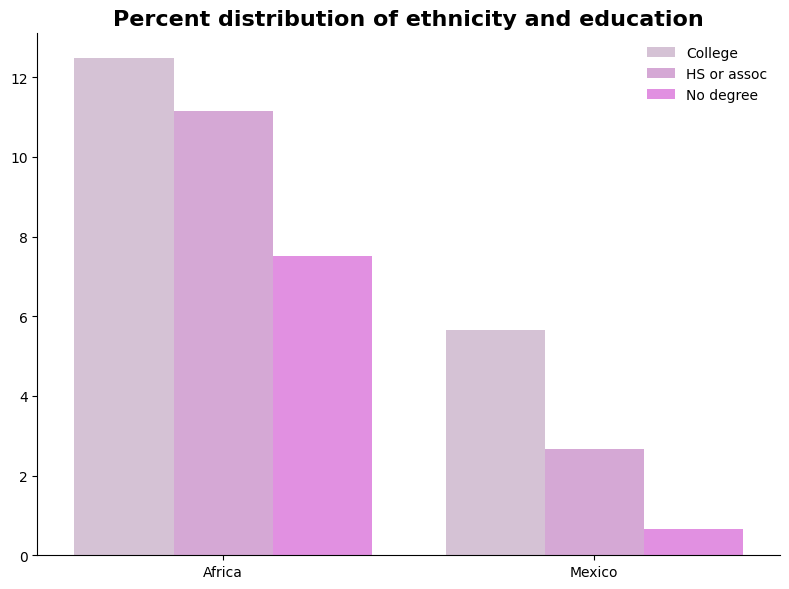

In [122]:
gss_theo = gss_theo.dropna()

ethn_age_fig, ethn_age_ax = crosstab_barplots(
    gss_theo,
    x="age_cat",
    y="ethnic",
    hue="ethnic",
    weight="wtssall",
    psu="vpsu",
    palette=["lightcoral", "springgreen"],
    title="Percent distribution of ethnicity and binned age",
)

ethn_inc_fig, ethn_inc_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="coninc_quantiles",
    hue="coninc_quantiles",
    weight="wtssall",
    psu="vpsu",
    palette=["lightskyblue", "lightsteelblue", "cornflowerblue", "royalblue"],
    title="Percent distribution of ethnicity and income quantiles"
)

ethn_sex_fig, ethn_sex_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="sex",
    hue="sex",
    weight="wtssall",
    psu="vpsu",
    palette=["orchid", "mediumslateblue"],
    title="Percent distribution of ethnicity and sex"
)

ethn_degree_fig, ethn_degree_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="degree",
    hue="degree",
    weight="wtssall",
    psu="vpsu",
    palette=["thistle", "plum", "violet"],
    title="Percent distribution of ethnicity and education"
)